<a href="https://colab.research.google.com/github/lisannedemoel/TM10007-Python/blob/main/FinalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

# Loading all necessary packages

In [ ]:
import pandas as pd
import numpy as np
import os

# Data loading functions
from hn.load_data import load_data

# Import for scaling
from sklearn import preprocessing

# Import for pipeline 
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, RFECV
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold, StratifiedKFold

# Import for classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from operator import itemgetter

# Import ROC curve and plot functions
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit
import seaborn as sb

# For Confusion matrix
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, classification_report

# Save results to google drive
# from google.colab import drive
# drive.mount('drive')

## Data loading and preprocessing


In [ ]:
# Load data of head and neck cancer
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Deleting missing data 
data_df = pd.DataFrame(data) 
data_df.dropna(axis=0, how='any')

# Splitting labels and features
label = data_df['label']
features = data_df.drop(['label'], axis=1)

# Remove features with zero variance
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(features)

len(features.columns[constant_filter.get_support()])

constant_columns = [column for column in features.columns
                    if column not in features.columns[constant_filter.get_support()]]

features.drop(labels=constant_columns, axis=1, inplace=True)
print(f'The features with zero variance are: {constant_columns}')

# Check data on outliers
Q1 = np.percentile(features, 25, axis=0)
Q3 = np.percentile(features, 75, axis=0)

IQR = Q3 - Q1

outliers = (features < (Q1 - 1.5 * IQR))| (features > (Q3 + 1.5 * IQR))
number_of_outliers = outliers.sum()
print(f'The number of outliers per colum: \n{number_of_outliers}')

features = np.array(features, dtype=float)

# Rename labels: change T12 to 0 and T34 to 1
samples_T12 = 0
samples_T34 = 0
for elem, num in enumerate(label):
  if num == 'T12':
    label[elem] = 0
    samples_T12 += 1
  elif num == 'T34':
    label[elem] = 1
    samples_T34 += 1
label = np.array(label, dtype=int)

print(f'The number of samples with a T12 score is: {samples_T12}')
print(f'The number of samples with a T34 score is: {samples_T34}')

The number of samples: 113
The number of columns: 160
The features with zero variance are: ['tf_LBP_peak_R15_P36', 'tf_LBP_peak_R3_P12']
The number of outliers per colum: 
hf_energy               8
hf_entropy              0
hf_kurtosis             5
hf_max                  8
hf_mean                 1
                       ..
tf_NGTDM_Busyness      20
tf_NGTDM_Coarseness     0
tf_NGTDM_Complexity    15
tf_NGTDM_Contrast      20
tf_NGTDM_Strength      16
Length: 157, dtype: int64
The number of samples with a T12 score is: 58
The number of samples with a T34 score is: 55


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Pipeline 
The pipeline function is made to analyze the best combination of the scaling method, the feature selection method and the classification method


In [ ]:
# Define different scalers
scaler_SC = preprocessing.StandardScaler()
scaler_MM = preprocessing.MinMaxScaler()
scaler_RC = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
all_scalers = {'Standard Scaler': scaler_SC, 
               'MinMaxScaler': scaler_MM, 
               'RobustScaler': scaler_RC}

# Define different feature extraction methods 
PCA = PCA(n_components=0.9, random_state=8)
FS = SelectKBest(score_func=f_classif, k=50)
all_fs_methods = {'PCA': PCA, 
               'FS': FS,
               } 

# Split data into design and test set
fr_test = 0.1 
x_design, x_test, y_design, y_test = train_test_split(features, label, stratify=label, test_size=fr_test, random_state=8)

parameters = \
    [\
     {'name': ['LogisticRegression'],
      'clf': [LogisticRegression(solver='liblinear')],
      'clf__penalty': ['l1', 'l2'],
      'clf__C': loguniform(1e-3, 1e2),   
     },

     {'name': ['SVM'],
      'clf': [SVC(probability=True)],
      'clf__C': loguniform(1e0, 1e3),
      'clf__gamma': loguniform(1e-4, 1e-3),
      'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
     },
     
     {'name': ['RandomForestClassifier'],
      'clf': [RandomForestClassifier()],
      'clf__n_estimators': randint(1, 50),
      },
     
     {'name': ['KNeighborsClassifier'],
      'clf': [KNeighborsClassifier()],
      'clf__n_neighbors': randint(1,30),
      'clf__weights':['uniform', 'distance']   
     }
       ]



rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=8)  
result_temp = []
result = []


for train_index, val_index in rskf.split(x_design, y_design):
  x_train, x_val = x_design[train_index], x_design[val_index]
  y_train, y_val = y_design[train_index], y_design[val_index]

  for params in parameters:


    for scaler in all_scalers:
      for fs in all_fs_methods:
      
        clf = params['clf'][0]
        name = params['name'][0]
        
        
        # Creating steps for the Pipeline
        steps = [('scaler', all_scalers[scaler]), ('Feature selection', FS), ('Feature Transformation', PCA), ('clf', clf)]

        # Hyperparameter optimization using Randomized Search
        param_distr = dict(params)
        param_distr.pop('clf')
        param_distr.pop('name')
        grid = RandomizedSearchCV(Pipeline(steps), param_distributions=param_distr, random_state=8)
        grid.fit(x_train, y_train)
        
        
        # Storing results 
        result_temp.append\
              (
                  {
                      'scaler': scaler,
                      'feature selection': fs,
                      'classifier': name,
                      'best params': grid.best_params_,
                      'score': grid.score(x_val,y_val)
                  }
                  \
              )
        param_distr = {}
  # Sorting result by best score, creating top 5
  result_temp = sorted(result_temp, key=itemgetter('score'), reverse=True)
  result.append(result_temp[0:5])
  result_temp = []

# Change result dictionary to dataframe
result_df = pd.DataFrame.from_dict(result)
print(result_df)

# Save results on drive as. csv file 
# result_df.to_csv('data_test_final5.csv')
# !cp data_test_final5.csv "drive/My Drive/"

Streaminguitvoer ingekort tot de laatste 5000 regels.
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [142] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [145] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [142] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  

                                                    0  ...                                                  4
0   {'scaler': 'Standard Scaler', 'feature selecti...  ...  {'scaler': 'MinMaxScaler', 'feature selection'...
1   {'scaler': 'MinMaxScaler', 'feature selection'...  ...  {'scaler': 'Standard Scaler', 'feature selecti...
2   {'scaler': 'MinMaxScaler', 'feature selection'...  ...  {'scaler': 'MinMaxScaler', 'feature selection'...
3   {'scaler': 'Standard Scaler', 'feature selecti...  ...  {'scaler': 'MinMaxScaler', 'feature selection'...
4   {'scaler': 'Standard Scaler', 'feature selecti...  ...  {'scaler': 'RobustScaler', 'feature selection'...
5   {'scaler': 'RobustScaler', 'feature selection'...  ...  {'scaler': 'Standard Scaler', 'feature selecti...
6   {'scaler': 'MinMaxScaler', 'feature selection'...  ...  {'scaler': 'MinMaxScaler', 'feature selection'...
7   {'scaler': 'MinMaxScaler', 'feature selection'...  ...  {'scaler': 'Standard Scaler', 'feature selecti...
8   {'scal

# Parameter optimization final classifier
Final classifier is selected based on occurrence in the top five results of the previous pipeline. 

In [ ]:
# Parameters based on randomized search
parameters_RF =  {
      'RF__n_estimators': randint(1, 64),
}
       
 
result_RF = []

for train_index, test_index in rskf.split(features, label):
  x_train, x_test = features[train_index], features[test_index]
  y_train, y_test = label[train_index], label[test_index]
 
  
  # Creating steps for the Pipeline
  steps = [('scaler', all_scalers['Standard Scaler']), ('PCA', PCA), ('RF', RandomForestClassifier())]
  
  # Hyperparameter optimization using Randomized Search
  grid = RandomizedSearchCV(Pipeline(steps), param_distributions=parameters_RF)
  grid.fit(x_train, y_train)
  
  # Storing results 
  result_RF.append\
        (
            {
                'grid': grid,
                'classifier': grid.best_estimator_,
                'best score': grid.best_score_,
                'best params': grid.best_params_,
            }
            \
        )
  

# Sorting result by best score
result_RF = sorted(result_RF, key=itemgetter('best score'), reverse=True)

# Change result dictionary to dataframe
result_RF_df = pd.DataFrame.from_dict(result_RF)
print(result_RF_df)

# Import results on drive as .csv file 
# result_RF_df.to_csv('data_RF.csv')
# !cp data_RF.csv "drive/My Drive/"

                                                 grid  ...               best params
0   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 34}
1   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 18}
2   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 38}
3   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 45}
4   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 25}
5   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...   {'RF__n_estimators': 8}
6   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 58}
7   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 15}
8   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 55}
9   RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF__n_estimators': 45}
10  RandomizedSearchCV(cv=None, error_score=nan,\n...  ...  {'RF_

# Compute ROC curve

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=8, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('RF',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=45, n_jobs=No

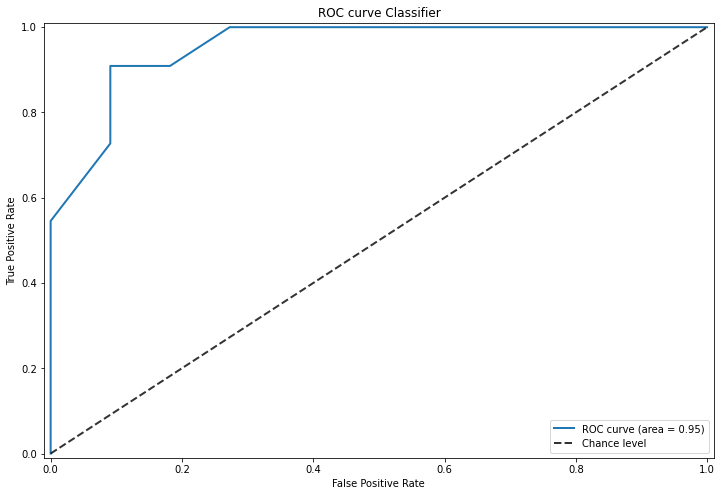

In [ ]:
# Define best estimator
classifier = grid.best_estimator_
print(classifier)
y_score = classifier.predict_proba(x_test)[:,1] 

# Compute ROC curve and ROC area 
fpr, tpr, __ = roc_curve(y_test, y_score)  
roc_auc = auc(fpr, tpr)

# Plot ROC curve 
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve Classifier')
plt.legend(loc="lower right")

# Learning curve

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

  FitFailedWarning)


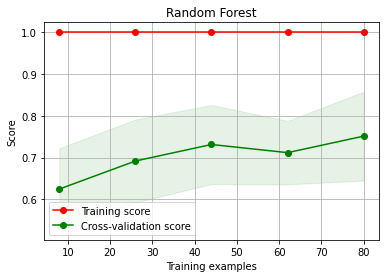

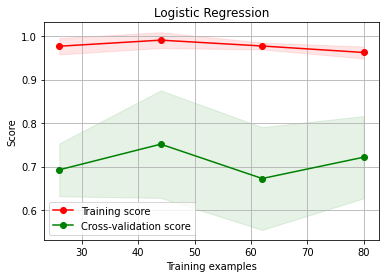

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plots of the learning curves

   """
    if axes is None:
        _, axes = plt.subplots()

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")


cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator_RF = RandomForestClassifier(n_estimators=46) 
estimator_LR = LogisticRegression(C=0.12934629940147027, penalty='l2')
scaler_SC.fit(x_design)
x_design_SC = scaler_SC.transform(x_design)


# combine the estimators
estimators = [estimator_RF, estimator_LR]

# add titles
names_clf = ['Random Forest', 'Logistic Regression']

k = 0
# plot the learning curves
for estimator in estimators:
    title= names_clf[k]
    plot_learning_curve(estimator, title, x_design_SC, y_design)
  
    k+=1
plt.show()

# Evaluating classifier

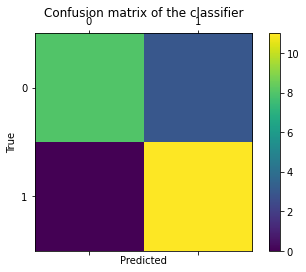

The accuracy of the classifier is 0.8636363636363636
The recall of the classifier is 1.0
The precision of the classifier is 0.7857142857142857
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.79      1.00      0.88        11

    accuracy                           0.86        22
   macro avg       0.89      0.86      0.86        22
weighted avg       0.89      0.86      0.86        22



In [ ]:
# Define confusion matrix
label_plot = [0, 1]
y_pred = classifier.predict(x_test)
confusionmatrix = confusion_matrix(y_test, y_pred, label_plot)


# Calculate evaluation parameters from confusion matrix 
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusionmatrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + label_plot)
ax.set_yticklabels([''] + label_plot)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print(f'The accuracy of the classifier is {accuracy}')
print(f'The recall of the classifier is {recall}')
print(f'The precision of the classifier is {precision}')

print(classification_report(y_test, y_pred, labels=label_plot))


# PCA pairplot
The code below was used to visualize the first five components of PCA.


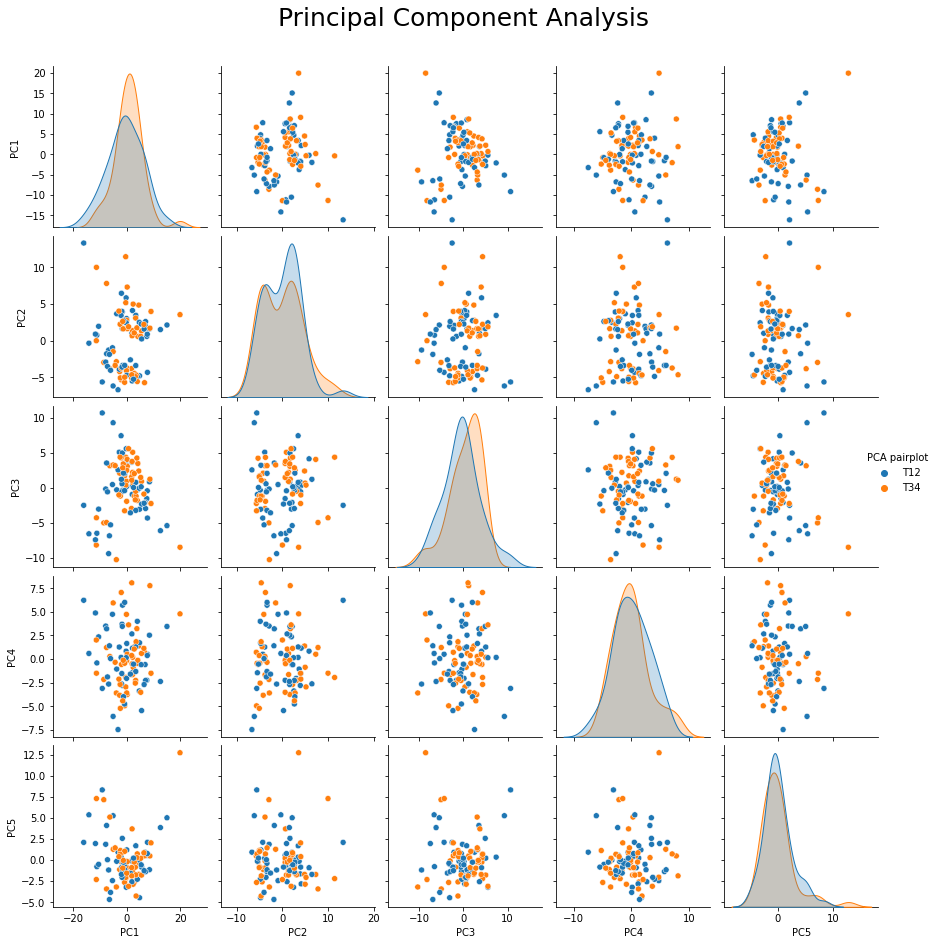

In [ ]:
# Making a copy of features from the design set
features_tpca = x_design

# Standard scaler
scaler_SC_tpca = preprocessing.StandardScaler()
scaler_SC_tpca.fit(features_tpca)
features_SC_tpca = scaler_SC_tpca.transform(features_tpca)

# PCA with 5 components
tpca = decomposition.PCA(n_components=5)
tpca.fit(features_SC_tpca)
X_TPCA = tpca.transform(features_SC_tpca)

# Convert all data to 1 data_frame
X_TPCA = pd.DataFrame(X_TPCA)
label2 = pd.DataFrame(label)
PCA_5 = pd.concat([X_TPCA, label2], axis=1,  join="outer")
PCA_5.columns = ['PC1','PC2','PC3',
                      'PC4','PC5','label2']

# Pairplot of PCA with legend
pc_pairplot = sb.pairplot(PCA_5, hue='label2')
pc_pairplot.fig.suptitle('Principal Component Analysis', y=1.05, size=25)
new_title = 'PCA pairplot'
pc_pairplot._legend.set_title(new_title)
new_labels = ['T12', 'T34']
for t, l in zip(pc_pairplot._legend.texts, new_labels): t.set_text(l)

# Feature selection RFECV
The code below was used to check whether RFECV is a stable feature selection method.

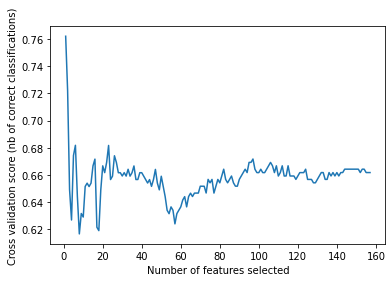

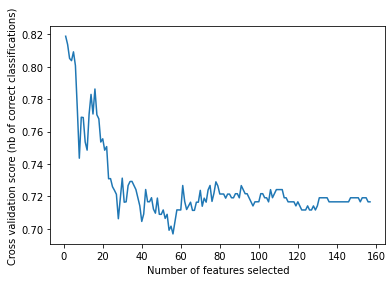

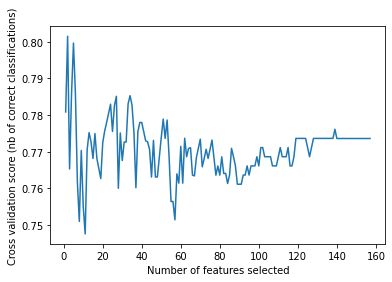

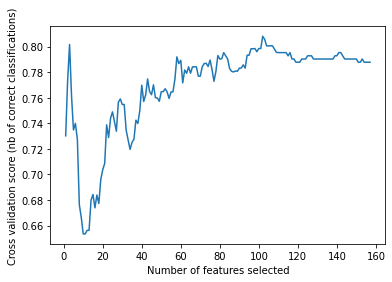

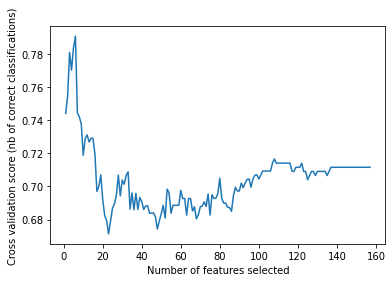

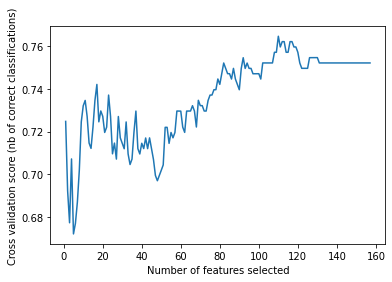

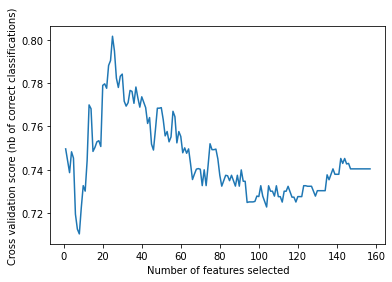

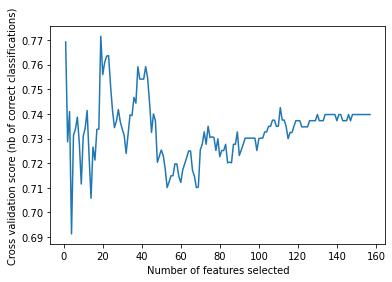

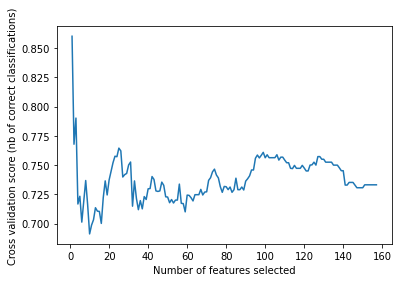

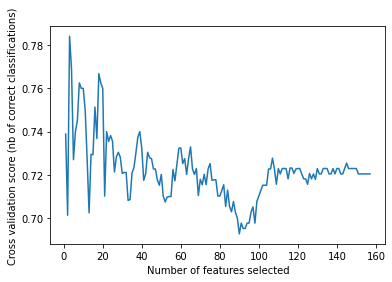

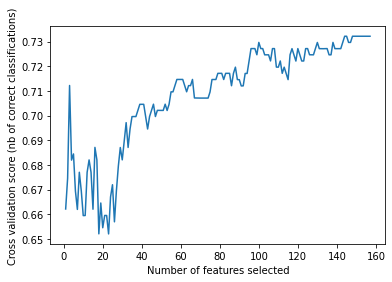

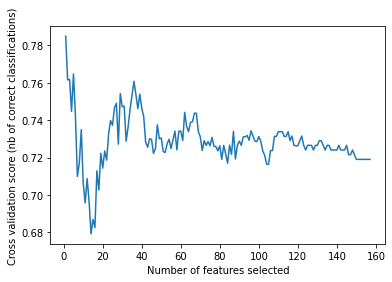

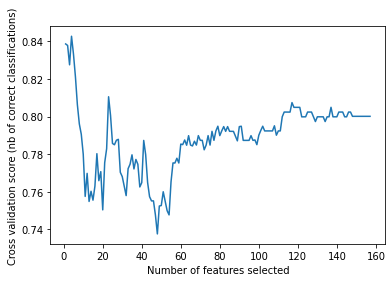

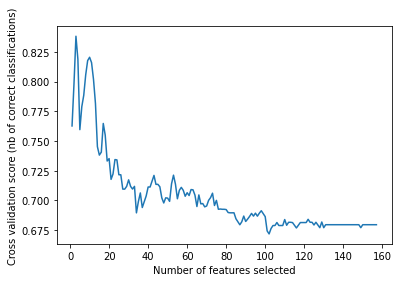

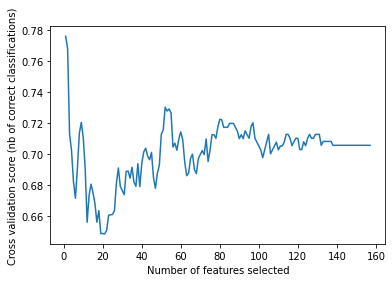

In [ ]:
# Test RFECV on every iteration for stability
for train_index, val_index in rskf.split(x_design, y_design):
  x_train, x_val = x_design[train_index], x_design[val_index]
  y_train, y_val = y_design[train_index], y_design[val_index]

  scaler_SC.fit(x_train)
  x_train_SC = scaler_SC.transform(x_train)

  rfecv = RFECV(
      estimator=SVC(kernel='linear'), step=1, 
      cv=StratifiedKFold(4),
      scoring='roc_auc')
  rfecv.fit(x_train_SC, y_train)

  # Plot number of features VS. cross-validation scores
  f = plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
  plt.show()
  # f.savefig("f.png")
  # files.download("f.png") 

# Feature selection Univariate 
The code below was used to check whether Univariate Feature Selection is a stable feature selection method and for plotting the features.


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [142] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [145] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [142 145] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packag

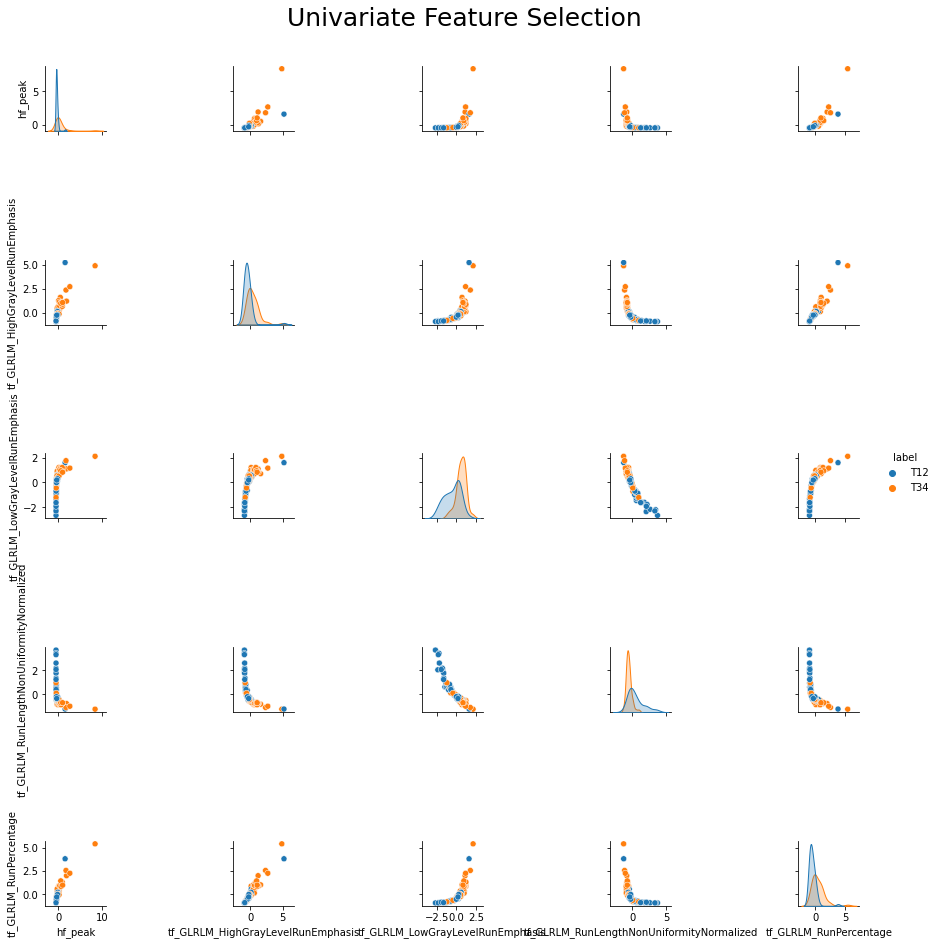

In [ ]:
# Find best features for every iteration
result_fs = []

for train_index, val_index in rskf.split(x_design, y_design):
  x_train, x_val = x_design[train_index], x_design[val_index]
  y_train, y_val = y_design[train_index], y_design[val_index]

  scaler_SC.fit(x_train)
  x_train_SC = scaler_SC.transform(x_train)

  # define feature selection 
  fs = SelectKBest(score_func=f_classif, k=20)
  fs.fit(x_train, y_train)
  mask = fs.get_support(indices=True)
  mask = mask.tolist()
  result_fs.extend( 
       mask
  )

# Find incidence of feature in 15 iterations
[[x,result_fs.count(x)] for x in set(result_fs)]

# Prepare best 5 features for the plot
scaler_SC.fit(x_design)
x_design_SC =  pd.DataFrame(scaler_SC.transform(x_design))
fs_names = data_df.columns
fs_df = x_design_SC.iloc[:, [7, 36, 40, 43, 44]]
fs_df = pd.concat([fs_df, pd.DataFrame(y_design)], axis=1,  join="outer")
fs_df.columns = [str(fs_names[7]), str(fs_names[36]), str(fs_names[40]),str(fs_names[43]), str(fs_names[44]), 'label']
                 #'hf_peak' , 'tf_GLRLM_LongRunEmphasis', 'tf_GLRLM_RunEntropy','tf_GLRLM_RunPercentage',  'tf_GLRLM_RunVariance', 'label']

# Make a pairplot of the 5 best performing stable features
pc_pairplot = sb.pairplot(fs_df, hue='label')
pc_pairplot.fig.suptitle('Univariate Feature Selection', y=1.05, size=25)
new_labels = ['T12', 'T34']
for t, l in zip(pc_pairplot._legend.texts, new_labels): t.set_text(l)